# Импортируем необходимые библиотеки

In [1]:
!pip install catboost
!pip install xgboost
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 18.7 MB/s eta 0:00:00


In [2]:
import os
import pandas as pd
import numpy as np

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split

from catboost import CatBoostClassifier, Pool
from xgboost import XGBClassifier
import lightgbm as lgb

import optuna

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

# Загрузим данные

In [3]:
ROOT_DIR = 'mlcourse-dota2-win-prediction'

train_features = pd.read_csv(os.path.join(ROOT_DIR, 'train_features.csv'), index_col='match_id_hash')
train_targets = pd.read_csv(os.path.join(ROOT_DIR, 'train_targets.csv'), index_col='match_id_hash')

In [4]:
train_features.head(2)

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,d5_stuns,d5_creeps_stacked,d5_camps_stacked,d5_rune_pickups,d5_firstblood_claimed,d5_teamfight_participation,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed
match_id_hash,,,,,,,,,,,,,,,,,,,,,
a400b8f29dece5f4d266f49f1ae2e98a,155,22,7,1,11,11,0,0,0,0,...,0.0,0,0,0,0,0.0,0,0,0,0
b9c57c450ce74a2af79c9ce96fac144d,658,4,0,3,10,15,7,2,0,7,...,0.0,0,0,0,0,0.0,0,0,0,0


In [5]:
train_targets.head(2)

,game_time,radiant_win,duration,time_remaining,next_roshan_team
match_id_hash,,,,,
a400b8f29dece5f4d266f49f1ae2e98a,155,False,992,837,NaN
b9c57c450ce74a2af79c9ce96fac144d,658,True,1154,496,NaN


In [6]:
X = train_features
y = train_targets['radiant_win']

# EDA (5 баллов)

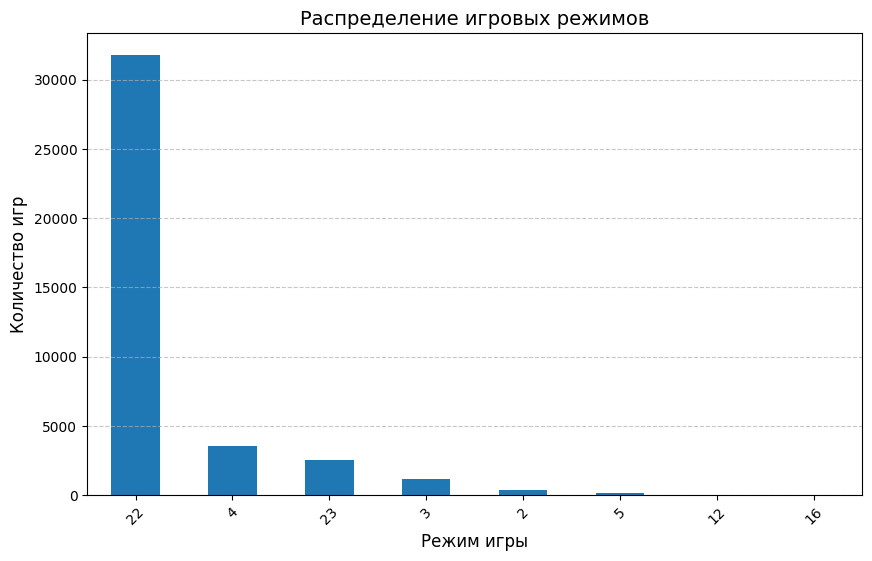

In [7]:
game_mode_counts = train_features['game_mode'].value_counts().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
game_mode_counts.plot(kind='bar')
plt.title('Распределение игровых режимов', fontsize=14)
plt.xlabel('Режим игры', fontsize=12)
plt.ylabel('Количество игр', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Text(0, 0.5, 'Number of Matches')

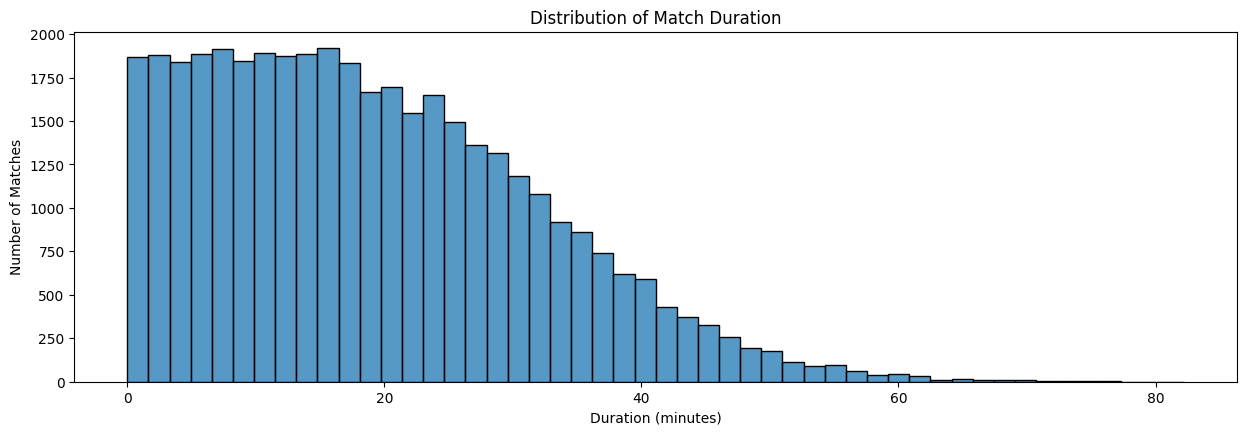

In [8]:
plt.figure(figsize=(15, 10))

train_features['duration_minutes'] = train_features['game_time'] / 60

plt.subplot(2, 1, 1)
sns.histplot(data=train_features, x='duration_minutes', bins=50)
plt.title('Distribution of Match Duration')
plt.xlabel('Duration (minutes)')
plt.ylabel('Number of Matches')

([0, 1, 2, 3, 4, 5, 6, 7],
 [Text(0, 0, '2'),
  Text(1, 0, '3'),
  Text(2, 0, '4'),
  Text(3, 0, '5'),
  Text(4, 0, '12'),
  Text(5, 0, '16'),
  Text(6, 0, '22'),
  Text(7, 0, '23')])

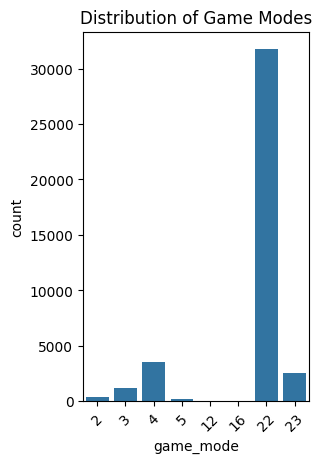

In [9]:
plt.subplot(1, 2, 1)
sns.countplot(data=train_features, x='game_mode')
plt.title('Distribution of Game Modes')
plt.xticks(rotation=45)

In [10]:
key_features = ['kills', 'deaths', 'assists', 'gold', 'xp', 'level']
plt.figure(figsize=(15, 10))

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

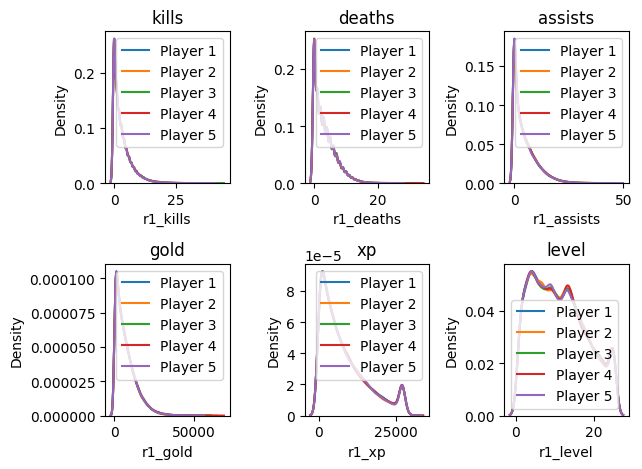

In [11]:
for i, feature in enumerate(key_features, 1):
    plt.subplot(2, 3, i)
    for player in range(1, 6):
        sns.kdeplot(data=train_features[f'r{player}_{feature}'], label=f'Player {player}')
    plt.title(f'{feature}')
    plt.legend()
plt.tight_layout()
plt.show()

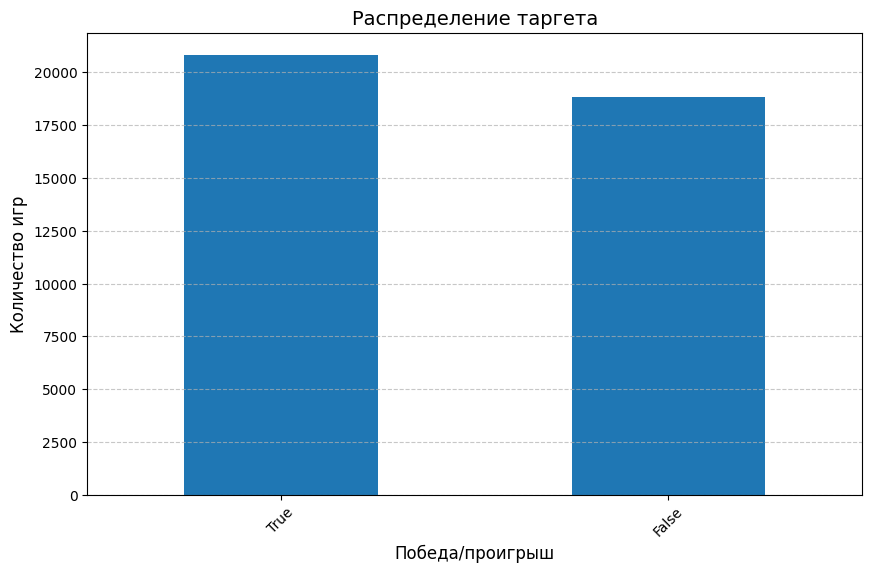

In [12]:
plt.figure(figsize=(10, 6))
train_targets['radiant_win'].value_counts().plot(kind='bar')
plt.title('Распределение таргета', fontsize=14)
plt.xlabel('Победа/проигрыш', fontsize=12)
plt.ylabel('Количество игр', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

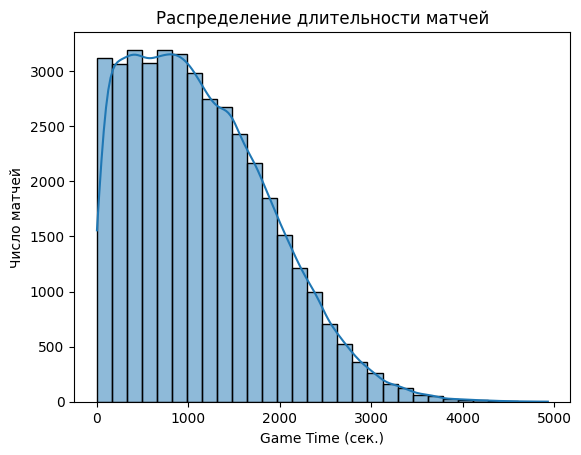

In [13]:
sns.histplot(train_features['game_time'], bins=30, kde=True)
plt.title('Распределение длительности матчей')
plt.xlabel('Game Time (сек.)')
plt.ylabel('Число матчей')
plt.show()

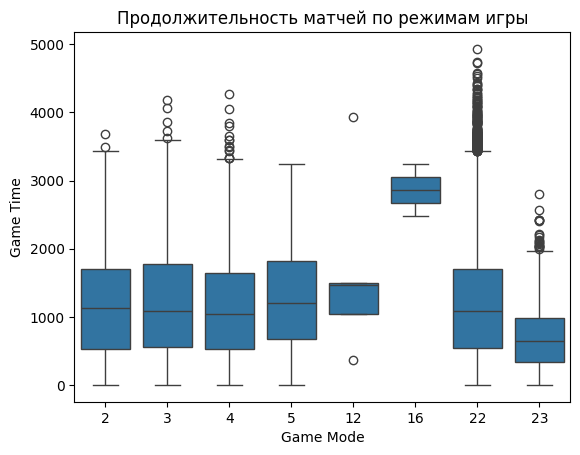

In [14]:
game_mode_counts = train_features['game_mode'].nunique()

sns.boxplot(x='game_mode', y='game_time', data=train_features)
plt.title('Продолжительность матчей по режимам игры')
plt.xlabel('Game Mode')
plt.ylabel('Game Time')
plt.show()

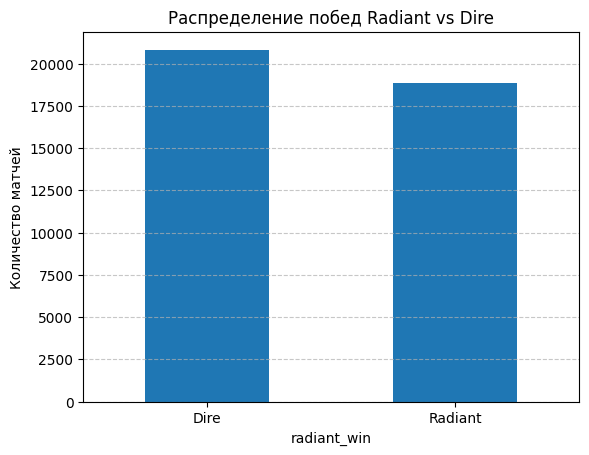

In [15]:
train_targets['radiant_win'].value_counts().plot(kind='bar')
plt.title('Распределение побед Radiant vs Dire')
plt.xticks([0,1], ['Dire', 'Radiant'], rotation=0)
plt.ylabel('Количество матчей')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

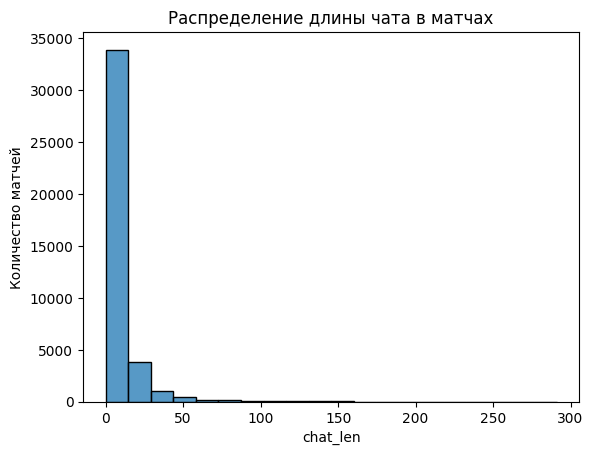

In [16]:
sns.histplot(train_features['chat_len'], bins=20, kde=False)
plt.title('Распределение длины чата в матчах')
plt.xlabel('chat_len')
plt.ylabel('Количество матчей')
plt.show()

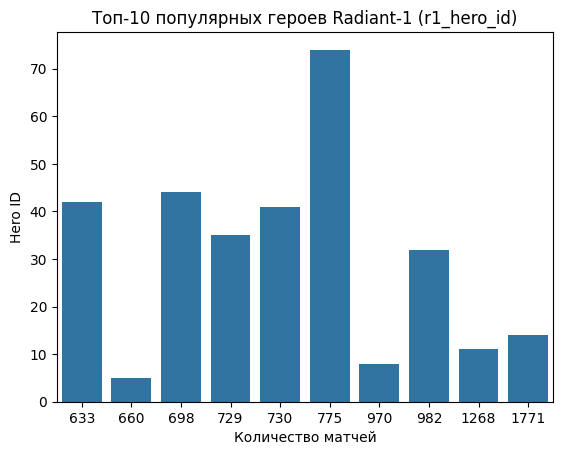

In [17]:
top_heroes = train_features['r1_hero_id'].value_counts().nlargest(10).reset_index()
top_heroes.columns = ['r1_hero_id', 'count']

sns.barplot(x='count', y='r1_hero_id', data=top_heroes)
plt.title('Топ-10 популярных героев Radiant-1 (r1_hero_id)')
plt.xlabel('Количество матчей')
plt.ylabel('Hero ID')
plt.show()

# Обучим CatBoost на чистых данных и посмотрим на метрики

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=69)
oof_cat = np.zeros(len(X))

for fold, (train_idx, valid_idx) in enumerate(skf.split(X, y)):
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

    model = CatBoostClassifier(
        early_stopping_rounds=100,
        random_state=69,
        verbose=0,
        thread_count=4
    )
    model.fit(X_train, y_train, eval_set=(X_valid, y_valid))

    y_pred = model.predict_proba(X_valid)[:, 1]

    fold_roc_auc = roc_auc_score(y_valid, y_pred)
    fold_acc = accuracy_score(y_valid, y_pred > 0.5)
    print(f'FOLD {fold}, Validation ROC-AUC score: {fold_roc_auc:.4f}, Accuracy score: {fold_acc:.4f}')

    oof_cat[valid_idx] = y_pred

oof_roc_auc = roc_auc_score(y, oof_cat)
oof_accuracy = accuracy_score(y, oof_cat > 0.5)
print(f'\nOverall CAT OOF ROC-AUC: {oof_roc_auc:.4f}, OOF Accuracy: {oof_accuracy:.4f}')


FOLD 0, Validation ROC-AUC score: 0.8187, Accuracy score: 0.7287
FOLD 1, Validation ROC-AUC score: 0.8029, Accuracy score: 0.7117
FOLD 2, Validation ROC-AUC score: 0.8007, Accuracy score: 0.7157
FOLD 3, Validation ROC-AUC score: 0.8047, Accuracy score: 0.7176
FOLD 4, Validation ROC-AUC score: 0.8060, Accuracy score: 0.7146

Overall CAT OOF ROC-AUC: 0.8066, OOF Accuracy: 0.7176


# Генерация фичей (5 баллов)

Генерация фичей является одной из важнейших частей построения пайплайна машинного обучения. В данной части вам предлагается придумать и сгенерировать полезные фичи для модели. Важно: они должны повысить метрику. В качестве примера сгенерированы статистические фичи. Вы можете не использовать их, если не считаете их нужными.

In [ ]:
def fe(data):
    df = data.copy()

    def normalize_column(series):
        series_min = series.min()
        if series_min < 0:
            series = series - series_min + 1e-8
        series = series.replace([np.inf, -np.inf], np.nan)
        if series.isna().any():
            series = series.fillna(series.median())
        return np.clip(series, -1e8, 1e8)

    metrics = [
        'kills', 'deaths', 'assists', 'gold', 'lh', 'xp',
        'stuns', 'creeps_stacked', 'camps_stacked', 'rune_pickups',
        'towers_killed', 'roshans_killed', 'obs_placed', 'sen_placed'
    ]

    for team in ['r', 'd']:
        team_kills = sum(df[f'{team}{i}_kills'] for i in range(1, 6))
        team_deaths = sum(df[f'{team}{i}_deaths'] for i in range(1, 6))

        df[f'{team}_smoothed_kda'] = (team_kills + 5) / (team_deaths + 5)

        df[f'{team}_fight_participation'] = team_kills / (team_kills + team_deaths + 1e-8)

    df['interaction_intensity'] = np.log1p(
        (df['chat_len'] + df['objectives_len']) /
        (df['game_time'] / 60 + 1)
    )

    for metric in metrics:
        radiant_cols = [f'r{i}_{metric}' for i in range(1, 6)]
        dire_cols = [f'd{i}_{metric}' for i in range(1, 6)]

        small_value = 1e-8

        df[f'radiant_team_{metric}'] = df[radiant_cols].sum(axis=1).pipe(normalize_column)
        df[f'dire_team_{metric}'] = df[dire_cols].sum(axis=1).pipe(normalize_column)

        team_ratio = df[f'radiant_team_{metric}'] / (df[f'dire_team_{metric}'] + small_value)
        df[f'team_{metric}_proportion'] = np.clip(team_ratio, -1e6, 1e6)

        for player_cols in [radiant_cols, dire_cols]:
            for col in player_cols:
                df[col] = normalize_column(df[col])
                df[f'{col}_log'] = np.log1p(df[col])
                df[f'{col}_root'] = np.sqrt(df[col].clip(0, None))
                df[f'{col}_squared'] = np.square(df[col])

        if metric in ['kills', 'deaths', 'assists', 'gold', 'xp']:
            df[f'radiant_mean_{metric}'] = df[radiant_cols].mean(axis=1).pipe(normalize_column)
            df[f'dire_mean_{metric}'] = df[dire_cols].mean(axis=1).pipe(normalize_column)

            spread_radiant = df[radiant_cols].max(axis=1) - df[radiant_cols].min(axis=1)
            df[f'radiant_range_{metric}'] = spread_radiant.pipe(normalize_column)

            spread_dire = df[dire_cols].max(axis=1) - df[dire_cols].min(axis=1)
            df[f'dire_range_{metric}'] = spread_dire.pipe(normalize_column)

            variability = df[radiant_cols].std(axis=1) / (df[f'radiant_mean_{metric}'] + small_value)
            df[f'radiant_variation_{metric}'] = np.clip(variability, -10, 10)

    duration_min = df['game_time'] / 60
    for team_prefix, team in [('r', 'radiant'), ('d', 'dire')]:
        efficiency = df[f'{team_prefix}_smoothed_kda'] / (df[f'{team}_team_gold']/1000 + small_value)
        df[f'{team}_performance_index'] = np.clip(efficiency, -100, 100)

        vision_rate = (df[f'{team}_team_obs_placed'] + df[f'{team}_team_sen_placed']) / (duration_min + 1)
        df[f'{team}_vision_control'] = np.clip(vision_rate, 0, 10)

    df['engagement_index'] = df['interaction_intensity'] * np.log1p(df['objectives_len'])
    df['communication_density'] = df['chat_len'] / (duration_min + 1)

    for col in df.columns:
        if df[col].dtype.kind in ['i', 'f']:
            df[col] = normalize_column(df[col])

    return df

# Теперь обучим CatBoost на данных с новыми фичами и посмотрим на метрики

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=69)
oof_cat = np.zeros(len(X))

for fold, (train_idx, valid_idx) in enumerate(skf.split(X, y)):
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

    # чтобы в тест не утекли глобальные статистики трейна, сначала сплитим, потом генерируем фичи
    X_train = fe(X_train)
    X_valid = fe(X_valid)

    model = CatBoostClassifier(
        early_stopping_rounds=100,
        random_state=69,
        verbose=0,
        thread_count=4
    )
    model.fit(X_train, y_train, eval_set=(X_valid, y_valid))

    y_pred = model.predict_proba(X_valid)[:, 1]

    fold_roc_auc = roc_auc_score(y_valid, y_pred)
    fold_acc = accuracy_score(y_valid, y_pred > 0.5)
    print(f'FOLD {fold}, Validation ROC-AUC score: {fold_roc_auc:.4f}, Accuracy score: {fold_acc:.4f}')

    oof_cat[valid_idx] = y_pred

oof_roc_auc = roc_auc_score(y, oof_cat)
oof_accuracy = accuracy_score(y, oof_cat > 0.5)
print(f'\nOverall OOF ROC-AUC: {oof_roc_auc:.4f}, OOF Accuracy: {oof_accuracy:.4f}')

FOLD 0, Validation ROC-AUC score: 0.8321, Accuracy score: 0.7405
FOLD 1, Validation ROC-AUC score: 0.8137, Accuracy score: 0.7211
FOLD 2, Validation ROC-AUC score: 0.8163, Accuracy score: 0.7279
FOLD 3, Validation ROC-AUC score: 0.8186, Accuracy score: 0.7316
FOLD 4, Validation ROC-AUC score: 0.8222, Accuracy score: 0.7325

Overall OOF ROC-AUC: 0.8205, OOF Accuracy: 0.7307


# Обработка категориальных фичей средствами CatBoost

Попробуем подать категориальные фичи в модель через cat_features.

In [ ]:
cats = ['game_mode', 'lobby_type']

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=69)
oof_cat = np.zeros(len(X))

for fold, (train_idx, valid_idx) in enumerate(skf.split(X, y)):
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

    # чтобы в тест не утекли глобальные статистики трейна, сначала сплитим, потом генерируем фичи
    X_train = fe(X_train)
    X_valid = fe(X_valid)

    model = CatBoostClassifier(
        cat_features=cats,
        early_stopping_rounds=100,
        random_state=69,
        verbose=0,
        thread_count=4
    )
    model.fit(X_train, y_train, eval_set=(X_valid, y_valid))

    y_pred = model.predict_proba(X_valid)[:, 1]

    fold_roc_auc = roc_auc_score(y_valid, y_pred)
    fold_acc = accuracy_score(y_valid, y_pred > 0.5)
    print(f'FOLD {fold}, Validation ROC-AUC score: {fold_roc_auc:.4f}, Accuracy score: {fold_acc:.4f}')

    oof_cat[valid_idx] = y_pred

oof_roc_auc = roc_auc_score(y, oof_cat)
oof_accuracy = accuracy_score(y, oof_cat > 0.5)
print(f'\nOverall CAT w/ FE OOF ROC-AUC: {oof_roc_auc:.4f}, OOF Accuracy: {oof_accuracy:.4f}')

FOLD 0, Validation ROC-AUC score: 0.8312, Accuracy score: 0.7382
FOLD 1, Validation ROC-AUC score: 0.8144, Accuracy score: 0.7210
FOLD 2, Validation ROC-AUC score: 0.8158, Accuracy score: 0.7288
FOLD 3, Validation ROC-AUC score: 0.8190, Accuracy score: 0.7330
FOLD 4, Validation ROC-AUC score: 0.8232, Accuracy score: 0.7345

Overall CAT w/ FE OOF ROC-AUC: 0.8207, OOF Accuracy: 0.7311


# Отбор фичей (5 баллов)

Возможно, на этапе генерации фичей вы решили прибегнуть к автоматической генерации (если нет, то советую обратить внимание на библиотеку OpenFE), или же просто генерировали все подряд. Также, возможно, исходные данные содержали бесполезные и шумные фичи.

Вам предлагается исследовать это и оставить только те фичи, которые вы считаете важными.

Идеи для отбора фичей:
- по feature importance
- по permutation importance
- по shap values
- recursive feature elimination
- sequential feature selection

Также обратите внимание на гайд от catboost: https://github.com/catboost/catboost/blob/master/catboost/tutorials/feature_selection/select_features_tutorial.ipynb

In [ ]:
model = CatBoostClassifier(
    cat_features=cats,
    random_state=69,
    verbose=0,
    thread_count=4,
    task_type='GPU'
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=69)

X_train = fe(X_train)
X_test = fe(X_test)

train_pool = Pool(X_train, y_train, cat_features=cats)
test_pool = Pool(X_test, y_test, cat_features=cats)

summary = model.select_features(
    train_pool,
    eval_set=test_pool,
    features_for_select=list(range(X_train.shape[1])),
    num_features_to_select=350,
    algorithm='RecursiveByShapValues',
    steps=5,
    shap_calc_type='Regular',
    train_final_model=False,
    plot=False
)



selected_features = summary['selected_features']

Learning rate set to 0.053367
Step #1 out of 5
bestTest = 0.5028816913
bestIteration = 735
Shrink model to first 736 iterations.
Feature #502 eliminated
Feature #18 eliminated
Feature #129 eliminated
Feature #114 eliminated
Feature #211 eliminated
Feature #81 eliminated
Feature #247 eliminated
Feature #227 eliminated
Feature #234 eliminated
Feature #468 eliminated
Feature #737 eliminated
Feature #229 eliminated
Feature #315 eliminated
Feature #36 eliminated
Feature #423 eliminated
Feature #39 eliminated
Feature #290 eliminated
Feature #111 eliminated
Feature #249 eliminated
Feature #533 eliminated
Feature #235 eliminated
Feature #500 eliminated
Feature #96 eliminated
Feature #350 eliminated
Feature #585 eliminated
Feature #407 eliminated
Feature #0 eliminated
Feature #534 eliminated
Feature #317 eliminated
Feature #704 eliminated
Feature #248 eliminated
Feature #252 eliminated
Feature #457 eliminated
Feature #212 eliminated
Feature #289 eliminated
Feature #705 eliminated
Feature #166 e

In [ ]:
new_cats = [col for col in cats if col in X_train.columns]
old_cats = cats[:]
cats = new_cats[:]

# Обучим модель на отобранных и фичах и посмотрим на метрики

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=69)
oof_cat = np.zeros(len(X))

for fold, (train_idx, valid_idx) in enumerate(skf.split(X, y)):
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

    X_train = fe(X_train).iloc[:, selected_features]
    X_valid = fe(X_valid).iloc[:, selected_features]

    model = CatBoostClassifier(
        cat_features=cats,
        early_stopping_rounds=100,
        random_state=69,
        verbose=0,
        thread_count=4,
        task_type='GPU'
    )
    model.fit(X_train, y_train, eval_set=(X_valid, y_valid))

    y_pred = model.predict_proba(X_valid)[:, 1]

    fold_roc_auc = roc_auc_score(y_valid, y_pred)
    fold_acc = accuracy_score(y_valid, y_pred > 0.5)
    print(f'FOLD {fold}, Validation ROC-AUC score: {fold_roc_auc:.4f}, Accuracy score: {fold_acc:.4f}')

    oof_cat[valid_idx] = y_pred

oof_roc_auc = roc_auc_score(y, oof_cat)
oof_accuracy = accuracy_score(y, oof_cat > 0.5)
print(f'\nOverall CAT w/ FE&FS OOF ROC-AUC: {oof_roc_auc:.4f}, OOF Accuracy: {oof_accuracy:.4f}')


FOLD 0, Validation ROC-AUC score: 0.8361, Accuracy score: 0.7430
FOLD 1, Validation ROC-AUC score: 0.8160, Accuracy score: 0.7248
FOLD 2, Validation ROC-AUC score: 0.8178, Accuracy score: 0.7285
FOLD 3, Validation ROC-AUC score: 0.8207, Accuracy score: 0.7316
FOLD 4, Validation ROC-AUC score: 0.8217, Accuracy score: 0.7341

Overall CAT w/ FE&FS OOF ROC-AUC: 0.8224, OOF Accuracy: 0.7324


# Блендинг: добавим XGBoost и LightGBM

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=69)
oof_lgb = np.zeros(len(X))

for fold, (train_idx, valid_idx) in enumerate(skf.split(X, y)):
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

    # чтобы в тест не утекли глобальные статистики трейна, сначала сплитим, потом генерируем фичи
    X_train = fe(X_train).iloc[:, selected_features]
    X_valid = fe(X_valid).iloc[:, selected_features]

    # lgbm требует указания категориальных фичей как 'category'
    for col in cats:
        X_train[col] = X_train[col].astype('category')
        X_valid[col] = X_valid[col].astype('category')

    model = lgb.LGBMClassifier(
        n_estimators=1000,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=69,
        n_jobs=4,
        metric='auc',
        early_stopping_round=100,
        verbosity=-1
    )
    model.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        categorical_feature=cats
    )

    y_pred = model.predict_proba(X_valid)[:, 1]

    fold_roc_auc = roc_auc_score(y_valid, y_pred)
    fold_acc = accuracy_score(y_valid, y_pred > 0.5)
    print(f'FOLD {fold}, Validation ROC-AUC score: {fold_roc_auc:.4f}, Accuracy score: {fold_acc:.4f}')

    oof_lgb[valid_idx] = y_pred

oof_roc_auc = roc_auc_score(y, oof_lgb)
oof_accuracy = accuracy_score(y, oof_lgb > 0.5)
print(f'\nOverall LGB w/ FE&FS OOF ROC-AUC: {oof_roc_auc:.4f}, OOF Accuracy: {oof_accuracy:.4f}')

FOLD 0, Validation ROC-AUC score: 0.8346, Accuracy score: 0.7445
FOLD 1, Validation ROC-AUC score: 0.8178, Accuracy score: 0.7261
FOLD 2, Validation ROC-AUC score: 0.8189, Accuracy score: 0.7328
FOLD 3, Validation ROC-AUC score: 0.8205, Accuracy score: 0.7356
FOLD 4, Validation ROC-AUC score: 0.8230, Accuracy score: 0.7353

Overall LGB w/ FE&FS OOF ROC-AUC: 0.8226, OOF Accuracy: 0.7349


In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=69)
oof_xgb = np.zeros(len(X))

for fold, (train_idx, valid_idx) in enumerate(skf.split(X, y)):
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

    # чтобы в тест не утекли глобальные статистики трейна, сначала сплитим, потом генерируем фичи
    X_train = fe(X_train).iloc[:, selected_features]
    X_valid = fe(X_valid).iloc[:, selected_features]

    # xgb требует указания категориальных фичей как 'category'
    for col in cats:
        X_train[col] = X_train[col].astype('category')
        X_valid[col] = X_valid[col].astype('category')

    cat_columns = [X_train.columns.get_loc(col) for col in cats]

    model = XGBClassifier(
        n_estimators=1000,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=69,
        n_jobs=4,
        eval_metric='auc',
        early_stopping_rounds=100,
        use_label_encoder=False,
        enable_categorical=True,
        tree_method='hist'
    )

    model.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        verbose=False
    )

    y_pred = model.predict_proba(X_valid)[:, 1]

    fold_roc_auc = roc_auc_score(y_valid, y_pred)
    fold_acc = accuracy_score(y_valid, y_pred > 0.5)
    print(f'FOLD {fold}, Validation ROC-AUC score: {fold_roc_auc:.4f}, Accuracy score: {fold_acc:.4f}')

    oof_xgb[valid_idx] = y_pred

oof_roc_auc = roc_auc_score(y, oof_xgb)
oof_accuracy = accuracy_score(y, oof_xgb > 0.5)
print(f'\nOverall XGB w/ FE&FS OOF ROC-AUC: {oof_roc_auc:.4f}, OOF Accuracy: {oof_accuracy:.4f}')

FOLD 0, Validation ROC-AUC score: 0.8351, Accuracy score: 0.7443
FOLD 1, Validation ROC-AUC score: 0.8151, Accuracy score: 0.7215
FOLD 2, Validation ROC-AUC score: 0.8185, Accuracy score: 0.7298
FOLD 3, Validation ROC-AUC score: 0.8201, Accuracy score: 0.7312
FOLD 4, Validation ROC-AUC score: 0.8221, Accuracy score: 0.7301

Overall XGB w/ FE&FS OOF ROC-AUC: 0.8218, OOF Accuracy: 0.7314


In [ ]:
# сблендим предсказания и посмотрим на метрики

oof_blend = (oof_cat + oof_lgb + oof_xgb) / 3

oof_roc_auc = roc_auc_score(y, oof_blend)
oof_accuracy = accuracy_score(y, oof_blend > 0.5)
print(f'\nOverall BLEND w/ FE&FS OOF ROC-AUC: {oof_roc_auc:.4f}, OOF Accuracy: {oof_accuracy:.4f}')


Overall BLEND w/ FE&FS OOF ROC-AUC: 0.8243, OOF Accuracy: 0.7349


# Подбор гиперпараметров (15 баллов)

Для изучения того, какие гиперпараметры доступны у модели для выбора можно использовать '? ModelName'
Определитесь с тем, какие гиперпараметры вы хотите оптимизировать и укажите их в objective. Выполните поиск гиперпараметров с Optuna

In [ ]:
? CatBoostClassifier

In [ ]:
? lgb.LGBMClassifier

In [ ]:
? XGBClassifier

In [ ]:
def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 500, 2000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-5, 10, log=True),
        'random_strength': trial.suggest_float('random_strength', 1e-5, 10),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide']),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 100),
        'loss_function': 'Logloss',
        'eval_metric': 'AUC',
        'task_type': 'CPU',
        'random_state': 69,
        'verbose': 0,
        'early_stopping_rounds': trial.suggest_int('early_stopping_rounds', 10, 50),
        'use_best_model': True
    }

    if 'cats' in globals():
        params['cat_features'] = cats

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=69)
    oof_cat = np.zeros(len(X))

    for train_idx, valid_idx in skf.split(X, y):
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

        X_train = fe(X_train).iloc[:, selected_features]
        X_valid = fe(X_valid).iloc[:, selected_features]

        model = CatBoostClassifier(**params)
        model.fit(
            X_train, y_train,
            eval_set=(X_valid, y_valid),
            early_stopping_rounds=100,
            verbose=0
        )

        y_pred = model.predict_proba(X_valid)[:, 1]
        oof_cat[valid_idx] = y_pred

    oof_roc_auc = roc_auc_score(y, oof_cat)

    return oof_roc_auc

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, timeout=3600)

cat_params = study.best_params
cat_params

[I 2025-06-03 12:08:01,160] A new study created in memory with name: no-name-38d88e55-1d8e-4575-8101-139b30f2ec4f
[I 2025-06-03 12:10:03,031] Trial 0 finished with value: 0.8164695242819378 and parameters: {'iterations': 614, 'learning_rate': 0.2787536612872392, 'depth': 6, 'l2_leaf_reg': 0.0035889467369102147, 'random_strength': 2.470371868275821, 'bagging_temperature': 0.3481701461323664, 'border_count': 173, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 63, 'early_stopping_rounds': 35}. Best is trial 0 with value: 0.8164695242819378.
[I 2025-06-03 12:16:36,319] Trial 1 finished with value: 0.8220480468905415 and parameters: {'iterations': 773, 'learning_rate': 0.011815543739544127, 'depth': 4, 'l2_leaf_reg': 0.00020849138330782314, 'random_strength': 0.2871874496403149, 'bagging_temperature': 0.11941497542464097, 'border_count': 240, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 44, 'early_stopping_rounds': 48}. Best is trial 1 with value: 0.8220480468905415.
[I 2025-06-03 12:21

{'iterations': 1489,
 'learning_rate': 0.015401480371739197,
 'depth': 9,
 'l2_leaf_reg': 0.4368657921456042,
 'random_strength': 9.163604688391223,
 'bagging_temperature': 0.33390491605035433,
 'border_count': 222,
 'grow_policy': 'Lossguide',
 'min_data_in_leaf': 2,
 'early_stopping_rounds': 37}

Дальше буду перебирать чуть поменьше в целях экономии времени

In [ ]:
def objective(trial):
    params = {
        'objective': 'binary',
        'metric': 'auc',
        'boosting_type': 'gbdt',
        'n_estimators': trial.suggest_int('n_estimators', 300, 1000),
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'learning_rate': trial.suggest_float('learning_rate', 0.05, 0.2),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 50),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.7, 1.0),
        'random_state': 69,
        'n_jobs': 4,
        'verbosity': -1,
        'early_stopping_rounds': 50,
    }

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=69)
    oof_lgb = np.zeros(len(X))

    for train_idx, valid_idx in skf.split(X, y):
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

        X_train = fe(X_train).iloc[:, selected_features]
        X_valid = fe(X_valid).iloc[:, selected_features]

        for col in cats:
            X_train[col] = X_train[col].astype('category')
            X_valid[col] = X_valid[col].astype('category')

        model = lgb.LGBMClassifier(**params)
        model.fit(
            X_train, y_train,
            eval_set=[(X_valid, y_valid)],
            categorical_feature=cats,
        )

        y_pred = model.predict_proba(X_valid)[:, 1]
        oof_lgb[valid_idx] = y_pred

    oof_roc_auc = roc_auc_score(y, oof_lgb)

    return oof_roc_auc

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, timeout=3600)

lgb_params = study.best_params
lgb_params

[I 2025-06-03 13:11:04,296] A new study created in memory with name: no-name-9a8cd9d4-294a-47cf-874c-812cf1bea44e
[I 2025-06-03 13:11:55,656] Trial 0 finished with value: 0.8211498972228388 and parameters: {'n_estimators': 753, 'num_leaves': 49, 'learning_rate': 0.05127361765993235, 'min_child_samples': 42, 'feature_fraction': 0.836436670321717}. Best is trial 0 with value: 0.8211498972228388.
[I 2025-06-03 13:12:38,349] Trial 1 finished with value: 0.816989572371493 and parameters: {'n_estimators': 708, 'num_leaves': 98, 'learning_rate': 0.09752109198425668, 'min_child_samples': 34, 'feature_fraction': 0.9417525065698693}. Best is trial 0 with value: 0.8211498972228388.
[I 2025-06-03 13:13:14,774] Trial 2 finished with value: 0.8212186707546936 and parameters: {'n_estimators': 549, 'num_leaves': 31, 'learning_rate': 0.07645359319898394, 'min_child_samples': 13, 'feature_fraction': 0.7515388389954908}. Best is trial 2 with value: 0.8212186707546936.
[I 2025-06-03 13:13:48,060] Trial 3 

{'n_estimators': 905,
 'num_leaves': 20,
 'learning_rate': 0.05028533145953267,
 'min_child_samples': 39,
 'feature_fraction': 0.9035379888798365}

In [ ]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 300, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.05, 0.2),
        'max_depth': trial.suggest_int('max_depth', 3, 8),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0, 0.5),
        'subsample': trial.suggest_float('subsample', 0.7, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1.0),
        'eval_metric': 'auc',
        'early_stopping_rounds': 50,
        'use_label_encoder': False,
        'enable_categorical': True,
        'tree_method': 'hist',
        'random_state': 69,
        'n_jobs': 4,
        'verbosity': 0,
    }

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=69)
    oof_xgb = np.zeros(len(X))

    for train_idx, valid_idx in skf.split(X, y):
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]


        X_train = fe(X_train).iloc[:, selected_features]
        X_valid = fe(X_valid).iloc[:, selected_features]

        for col in cats:
            X_train[col] = X_train[col].astype('category')
            X_valid[col] = X_valid[col].astype('category')

        model = XGBClassifier(**params)
        model.fit(
            X_train, y_train,
            eval_set=[(X_valid, y_valid)],
            verbose=False
        )

        y_pred = model.predict_proba(X_valid)[:, 1]
        oof_xgb[valid_idx] = y_pred

    oof_roc_auc = roc_auc_score(y, oof_xgb)

    return oof_roc_auc

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, timeout=3600)

xgb_params = study.best_params

[I 2025-06-03 13:44:03,843] A new study created in memory with name: no-name-67925b63-02a6-400d-8ea5-71448635775f
[I 2025-06-03 13:45:13,399] Trial 0 finished with value: 0.823172527380601 and parameters: {'n_estimators': 387, 'learning_rate': 0.09402777264659651, 'max_depth': 3, 'min_child_weight': 5, 'gamma': 0.2283582653274447, 'subsample': 0.9830809866585861, 'colsample_bytree': 0.9841398906525896}. Best is trial 0 with value: 0.823172527380601.
[I 2025-06-03 13:45:59,867] Trial 1 finished with value: 0.8190633820914925 and parameters: {'n_estimators': 516, 'learning_rate': 0.1202572507421004, 'max_depth': 6, 'min_child_weight': 6, 'gamma': 0.09511755907651093, 'subsample': 0.7034183671421982, 'colsample_bytree': 0.8724290909642998}. Best is trial 0 with value: 0.823172527380601.
[I 2025-06-03 13:47:06,311] Trial 2 finished with value: 0.8215700049925452 and parameters: {'n_estimators': 765, 'learning_rate': 0.06569884361648372, 'max_depth': 6, 'min_child_weight': 9, 'gamma': 0.046

# Обучим модели с новыми гиперпараметрами

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=69)
oof_cat = np.zeros(len(X))

for fold, (train_idx, valid_idx) in enumerate(skf.split(X, y)):
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

    # чтобы в тест не утекли глобальные статистики трейна, сначала сплитим, потом генерируем фичи
    X_train = fe(X_train).iloc[:, selected_features]
    X_valid = fe(X_valid).iloc[:, selected_features]

    model = CatBoostClassifier(
        **cat_params,
        random_state=69,
        verbose=0,
        thread_count=4
    )
    model.fit(X_train, y_train, eval_set=(X_valid, y_valid))

    y_pred = model.predict_proba(X_valid)[:, 1]

    fold_roc_auc = roc_auc_score(y_valid, y_pred)
    fold_acc = accuracy_score(y_valid, y_pred > 0.5)
    print(f'FOLD {fold}, Validation ROC-AUC score: {fold_roc_auc:.4f}, Accuracy score: {fold_acc:.4f}')

    oof_cat[valid_idx] = y_pred

oof_roc_auc = roc_auc_score(y, oof_cat)
oof_accuracy = accuracy_score(y, oof_cat > 0.5)
print(f'\nOverall Tuned CAT w/ FE&FS OOF ROC-AUC: {oof_roc_auc:.4f}, OOF Accuracy: {oof_accuracy:.4f}')

if 'model' in locals():
    model.save_model('cat.cbm')

FOLD 0, Validation ROC-AUC score: 0.8364, Accuracy score: 0.7473
FOLD 1, Validation ROC-AUC score: 0.8156, Accuracy score: 0.7273
FOLD 2, Validation ROC-AUC score: 0.8184, Accuracy score: 0.7274
FOLD 3, Validation ROC-AUC score: 0.8217, Accuracy score: 0.7327
FOLD 4, Validation ROC-AUC score: 0.8243, Accuracy score: 0.7370

Overall Tuned CAT w/ FE&FS OOF ROC-AUC: 0.8232, OOF Accuracy: 0.7343


In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=69)
oof_lgb = np.zeros(len(X))

for fold, (train_idx, valid_idx) in enumerate(skf.split(X, y)):
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

    # чтобы в тест не утекли глобальные статистики трейна, сначала сплитим, потом генерируем фичи
    X_train = fe(X_train).iloc[:, selected_features]
    X_valid = fe(X_valid).iloc[:, selected_features]

    # lgbm требует указания категориальных фичей как 'category'
    for col in cats:
        X_train[col] = X_train[col].astype('category')
        X_valid[col] = X_valid[col].astype('category')

    final_params = {
        **lgb_params,
        'objective': 'binary',
        'metric': 'auc',
        'boosting_type': 'gbdt',
        'random_state': 69,
        'n_jobs': 4,
        'verbosity': -1
    }

    model = lgb.LGBMClassifier(**final_params)
    model.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        categorical_feature=cats
    )

    y_pred = model.predict_proba(X_valid)[:, 1]

    fold_roc_auc = roc_auc_score(y_valid, y_pred)
    fold_acc = accuracy_score(y_valid, y_pred > 0.5)
    print(f'FOLD {fold}, Validation ROC-AUC score: {fold_roc_auc:.4f}, Accuracy score: {fold_acc:.4f}')

    oof_lgb[valid_idx] = y_pred
model.booster_.save_model('lgbm.txt')
oof_roc_auc = roc_auc_score(y, oof_lgb)
oof_accuracy = accuracy_score(y, oof_lgb > 0.5)
print(f'\nOverall Tuned LGB w/ FE&FS OOF ROC-AUC: {oof_roc_auc:.4f}, OOF Accuracy: {oof_accuracy:.4f}')

FOLD 0, Validation ROC-AUC score: 0.8317, Accuracy score: 0.7414
FOLD 1, Validation ROC-AUC score: 0.8170, Accuracy score: 0.7290
FOLD 2, Validation ROC-AUC score: 0.8170, Accuracy score: 0.7294
FOLD 3, Validation ROC-AUC score: 0.8166, Accuracy score: 0.7303
FOLD 4, Validation ROC-AUC score: 0.8202, Accuracy score: 0.7304

Overall Tuned LGB w/ FE&FS OOF ROC-AUC: 0.8203, OOF Accuracy: 0.7321


In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=69)
oof_xgb = np.zeros(len(X))

for fold, (train_idx, valid_idx) in enumerate(skf.split(X, y)):
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

    # чтобы в тест не утекли глобальные статистики трейна, сначала сплитим, потом генерируем фичи
    X_train = fe(X_train).iloc[:, selected_features]
    X_valid = fe(X_valid).iloc[:, selected_features]

    # xgb требует указания категориальных фичей как 'category'
    for col in cats:
        X_train[col] = X_train[col].astype('category')
        X_valid[col] = X_valid[col].astype('category')

    cat_columns = [X_train.columns.get_loc(col) for col in cats]

    final_params = {
        **xgb_params,
        'eval_metric': 'auc',
        'use_label_encoder': False,
        'enable_categorical': True,
        'tree_method': 'hist',
        'random_state': 69,
        'n_jobs': 4
    }

    model = XGBClassifier(**final_params)
    model.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        verbose=False
    )

    y_pred = model.predict_proba(X_valid)[:, 1]

    fold_roc_auc = roc_auc_score(y_valid, y_pred)
    fold_acc = accuracy_score(y_valid, y_pred > 0.5)
    print(f'FOLD {fold}, Validation ROC-AUC score: {fold_roc_auc:.4f}, Accuracy score: {fold_acc:.4f}')

    oof_xgb[valid_idx] = y_pred
model.save_model('xgb.json')
oof_roc_auc = roc_auc_score(y, oof_xgb)
oof_accuracy = accuracy_score(y, oof_xgb > 0.5)
print(f'\nOverall Tuned XGB w/ FE&FS OOF ROC-AUC: {oof_roc_auc:.4f}, OOF Accuracy: {oof_accuracy:.4f}')

FOLD 0, Validation ROC-AUC score: 0.8330, Accuracy score: 0.7405
FOLD 1, Validation ROC-AUC score: 0.8204, Accuracy score: 0.7319
FOLD 2, Validation ROC-AUC score: 0.8158, Accuracy score: 0.7258
FOLD 3, Validation ROC-AUC score: 0.8185, Accuracy score: 0.7239
FOLD 4, Validation ROC-AUC score: 0.8213, Accuracy score: 0.7316

Overall Tuned XGB w/ FE&FS OOF ROC-AUC: 0.8215, OOF Accuracy: 0.7307


In [ ]:
# сблендим предсказания и посмотрим на метрики

oof_blend = (oof_cat + oof_lgb + oof_xgb) / 3

oof_roc_auc = roc_auc_score(y, oof_blend)
oof_accuracy = accuracy_score(y, oof_blend > 0.5)
print(f'\nOverall Tuned BLEND w/ FE&FS OOF ROC-AUC: {oof_roc_auc:.4f}, OOF Accuracy: {oof_accuracy:.4f}')


Overall Tuned BLEND w/ FE&FS OOF ROC-AUC: 0.8250, OOF Accuracy: 0.7354


# Итоговая важность фичей

In [ ]:
cat_model = CatBoostClassifier()
cat_model.load_model('cat.cbm')
cb_imp = cat_model.get_feature_importance()


lgb_booster = lgb.Booster(model_file='lgbm.txt')
lgb_imp = lgb_booster.feature_importance(importance_type='gain')
lgb_features = lgb_booster.feature_name()



xgb_model = XGBClassifier()
xgb_model.load_model('xgb.json')
xgb_imp = xgb_model.get_booster().get_score(importance_type='weight')
xgb_imp = np.array([xgb_imp.get(f, 0) for f in X.columns]) if xgb_imp else None

In [ ]:
def get_imp(model_type, X, y, n_splits=5):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=69)
    importance = []
    for train_idx, _ in skf.split(X, y):
        X_train = X.iloc[train_idx]
        y_train = y.iloc[train_idx]

        if model_type == 'catboost':
            model = CatBoostClassifier(verbose=0).fit(X_train, y_train)
            imp = model.get_feature_importance()
        elif model_type == 'lightgbm':
            model = lgb.LGBMClassifier().fit(X_train, y_train)
            imp = model.feature_importances_
        elif model_type == 'xgboost':
            model = XGBClassifier().fit(X_train, y_train)
            imp = model.feature_importances_

        importance.append(imp)

    return np.mean(importance, axis=0), X.columns

In [ ]:
catb, features = get_imp('catboost', X, y)
lgb, _ = get_imp('lightgbm', X, y)
xgb, _ = get_imp('xgboost', X, y)

  File "C:\Users\vanyu\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


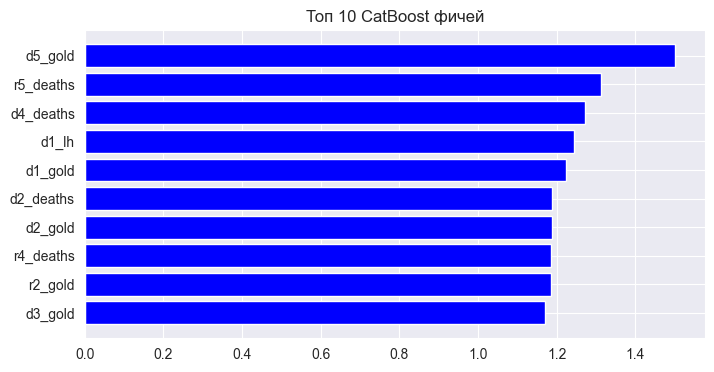

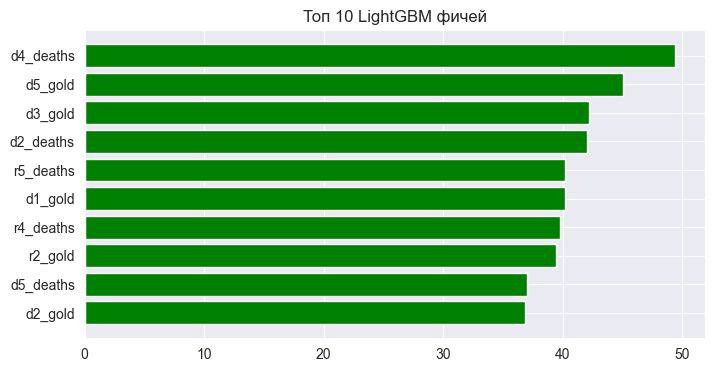

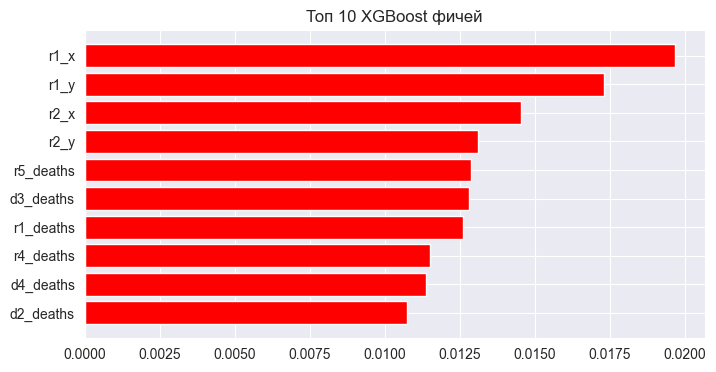

In [ ]:
top_n = 10
for imp, name in zip([catb, lgb, xgb], ['CatBoost', 'LightGBM', 'XGBoost']):
    idx = np.argsort(imp)[-top_n:]
    plt.figure(figsize=(8, 4))
    plt.barh(range(top_n), imp[idx], color=['blue', 'green', 'red'][['CatBoost', 'LightGBM', 'XGBoost'].index(name)])
    plt.yticks(range(top_n), features[idx])
    plt.title(f'Топ {top_n} {name} фичей')
    plt.show()